In [1]:
#Documentation
#https://www.kaggle.com/code/animeshhalder/google-brain-ventilator-pressure-prediction
#https://machinelearningmastery.com/xgboost-for-regression/
#https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/
#https://levelup.gitconnected.com/random-forest-regression-209c0f354c84#:~:text=Random%20Forest%20Regression%20is%20a%20supervised%20learning%20algorithm%20that%20uses,prediction%20than%20a%20single%20model.
#https://scikit-learn.org/stable/modules/model_evaluation.html
#https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
#https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
import numpy as np
import pandas as pd
import os
import glob
import io
import seaborn as sns
from xgboost import XGBRegressor
from google.colab import files
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install memory_profiler
%reload_ext memory_profiler

np.random.seed(42)
sns.set(color_codes=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#uploaded = files.upload()

In [3]:
data=pd.read_csv('vent.csv')
print(data)
print(data.dtypes)
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape)
print(data.isnull().sum())

              id  breath_id   R   C  time_step       u_in  u_out   pressure
0              1          1  20  50   0.000000   0.083334      0   5.837492
1              2          1  20  50   0.033652  18.383041      0   5.907794
2              3          1  20  50   0.067514  22.509278      0   7.876254
3              4          1  20  50   0.101542  22.808822      0  11.742872
4              5          1  20  50   0.135756  25.355850      0  12.234987
...          ...        ...  ..  ..        ...        ...    ...        ...
6035995  6035996     125749  50  10   2.504603   1.489714      1   3.869032
6035996  6035997     125749  50  10   2.537961   1.488497      1   3.869032
6035997  6035998     125749  50  10   2.571408   1.558978      1   3.798729
6035998  6035999     125749  50  10   2.604744   1.272663      1   4.079938
6035999  6036000     125749  50  10   2.638017   1.482739      1   3.869032

[6036000 rows x 8 columns]
id             int64
breath_id      int64
R              int

In [4]:
data.drop(['id'],axis = 1, inplace = True)
print(data)


         breath_id   R   C  time_step       u_in  u_out   pressure
0                1  20  50   0.000000   0.083334      0   5.837492
1                1  20  50   0.033652  18.383041      0   5.907794
2                1  20  50   0.067514  22.509278      0   7.876254
3                1  20  50   0.101542  22.808822      0  11.742872
4                1  20  50   0.135756  25.355850      0  12.234987
...            ...  ..  ..        ...        ...    ...        ...
6035995     125749  50  10   2.504603   1.489714      1   3.869032
6035996     125749  50  10   2.537961   1.488497      1   3.869032
6035997     125749  50  10   2.571408   1.558978      1   3.798729
6035998     125749  50  10   2.604744   1.272663      1   4.079938
6035999     125749  50  10   2.638017   1.482739      1   3.869032

[6036000 rows x 7 columns]


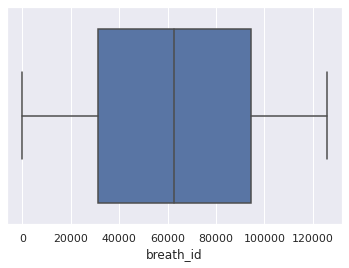

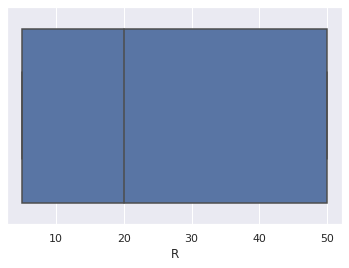

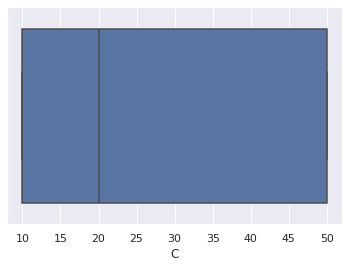

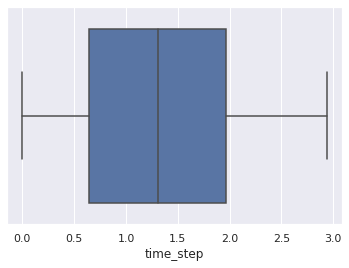

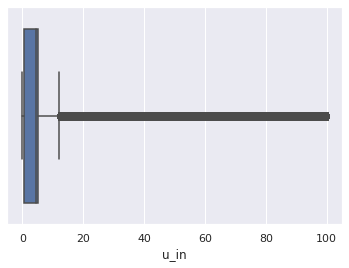

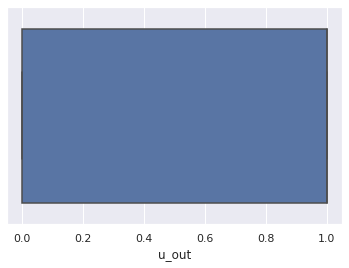

,breath_id,R,C,time_step,u_in,u_out,pressure
breath_id,1.000000,0.001860,0.007222,-0.000213,-0.002378,-0.000100,-0.002394
R,0.001860,1.000000,-0.096070,-0.014535,-0.148120,-0.007594,0.015976
C,0.007222,-0.096070,1.000000,0.004936,0.151002,0.003720,-0.036727
time_step,-0.000213,-0.014535,0.004936,1.000000,-0.352276,0.839191,-0.524829
u_in,-0.002378,-0.148120,0.151002,-0.352276,1.000000,-0.416985,0.308136
u_out,-0.000100,-0.007594,0.003720,0.839191,-0.416985,1.000000,-0.614910
pressure,-0.002394,0.015976,-0.036727,-0.524829,0.308136,-0.614910,1.000000


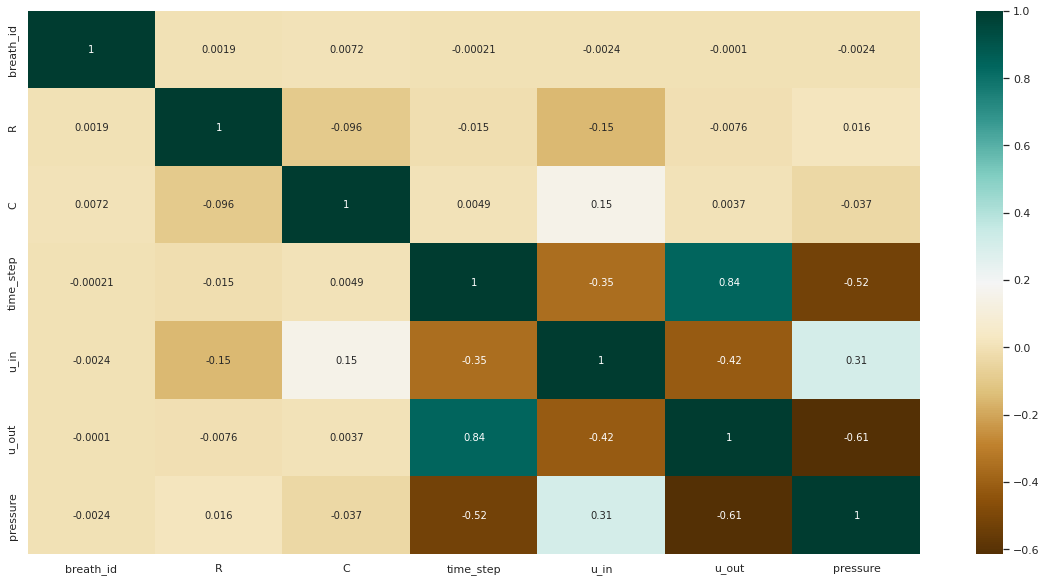

In [5]:
sns.boxplot(x=data['breath_id'])
plt.show()
sns.boxplot(x=data['R'])
plt.show()
sns.boxplot(x=data['C'])
plt.show()
sns.boxplot(x=data['time_step'])
plt.show()
sns.boxplot(x=data['u_in'])
plt.show()
sns.boxplot(x=data['u_out'])
plt.show()
plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [6]:
x = data.drop('pressure',axis = 1)
y = data['pressure']
%time %memit x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25,random_state= 42)
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)


peak memory: 1498.93 MiB, increment: 0.23 MiB
CPU times: user 2.3 s, sys: 1.07 s, total: 3.37 s
Wall time: 4.64 s


In [7]:
xgb_model=XGBRegressor()
%time %memit xgb_model.fit(x_train,y_train)
%time %memit xgb_predict=xgb_model.predict(x_test)

r2=r2_score(y_test,xgb_predict)
mean2_err=mean_squared_error(y_test,xgb_predict)
mean_abs_err=mean_absolute_error(y_test,xgb_predict)
exp_variance=explained_variance_score(y_test, xgb_predict)
print("R2 score: ",r2)
print("Mean Squared Error: ",mean2_err)
print("Mean Absolute Error: ",mean_abs_err)
print("Explained Variance Score: ",exp_variance)

[22:57:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:21] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
peak memory: 2336.11 MiB, increment: 441.02 MiB
CPU times: user 12min 8s, sys: 2.23 s, total: 12min 11s
Wall time: 12min 12s
peak memory: 2270.66 MiB, increment: 9.79 MiB
CPU times: user 4.47 s, sys: 290 ms, total: 4.76 s
Wall time: 4.86 s
R2 score:  0.6957378379933479
Mean Squared Error:  20.006871026051808
Mean Absolute Error:  2.46787150430199
Explained Variance Score:  0.6957378670993288


In [8]:
rf_model=RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
%time %memit rf_model.fit(x_train,y_train)
%time %memit rf_predict=rf_model.predict(x_test)

r22=r2_score(y_test,rf_predict)
mean2_err2=mean_squared_error(y_test,rf_predict)
mean_abs_err2=mean_absolute_error(y_test,rf_predict)
exp_variance2=explained_variance_score(y_test, rf_predict)
print("R2 score: ",r22)
print("Mean Squared Error: ",mean2_err2)
print("Mean Absolute Error: ", mean_abs_err2)
print("Explained Variance Score: ",exp_variance2)


peak memory: 2272.34 MiB, increment: 1.68 MiB
CPU times: user 3min 30s, sys: 783 ms, total: 3min 31s
Wall time: 3min 30s
peak memory: 2272.36 MiB, increment: 0.01 MiB
CPU times: user 1.79 s, sys: 172 ms, total: 1.96 s
Wall time: 2.08 s
R2 score:  0.7459735423327627
Mean Squared Error:  16.703603702264207
Mean Absolute Error:  2.1016551673431123
Explained Variance Score:  0.7459736233971914


In [9]:
knn_model=KNeighborsRegressor()
%time %memit knn_model.fit(x_train,y_train)
%time %memit knn_predict=knn_model.predict(x_test)

r23=r2_score(y_test,knn_predict)
mean2_err3=mean_squared_error(y_test,knn_predict)
mean_abs_err3=mean_absolute_error(y_test,knn_predict)
exp_variance3=explained_variance_score(y_test, knn_predict)
print("R2 score: ",r23)
print("Mean Squared Error: ",mean2_err3)
print("Mean Absolute Error: ", mean_abs_err3)
print("Explained Variance Score: ",exp_variance3)


peak memory: 2280.41 MiB, increment: 8.04 MiB
CPU times: user 20.2 s, sys: 462 ms, total: 20.7 s
Wall time: 20.7 s
peak memory: 2337.49 MiB, increment: 57.08 MiB
CPU times: user 2min 23s, sys: 367 ms, total: 2min 24s
Wall time: 2min 23s
R2 score:  0.7022778416284855
Mean Squared Error:  19.57683066751637
Mean Absolute Error:  2.211979408707695
Explained Variance Score:  0.7022992927663496


In [10]:
param_grid = {
    "n_estimators":[10,20,30],
    "max_depth":[10,20,30],
}
rf_model2=RandomForestRegressor()
%time %memit rf_model_tuned= GridSearchCV(estimator=rf_model2,param_grid=param_grid,cv=3,verbose=2)
%time %memit rf_model_tuned.fit(x_train,y_train)

rf_model_tuned.best_estimator_


peak memory: 2337.49 MiB, increment: 0.00 MiB
CPU times: user 115 ms, sys: 165 ms, total: 280 ms
Wall time: 484 ms
Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ......................max_depth=10, n_estimators=10; total time= 2.1min
[CV] END ......................max_depth=10, n_estimators=10; total time= 2.1min
[CV] END ......................max_depth=10, n_estimators=10; total time= 2.1min
[CV] END ......................max_depth=10, n_estimators=20; total time= 4.1min
[CV] END ......................max_depth=10, n_estimators=20; total time= 4.3min
[CV] END ......................max_depth=10, n_estimators=20; total time= 4.2min
[CV] END ......................max_depth=10, n_estimators=30; total time= 6.3min
[CV] END ......................max_depth=10, n_estimators=30; total time= 6.3min
[CV] END ......................max_depth=10, n_estimators=30; total time= 6.1min
[CV] END ......................max_depth=20, n_estimators=10; total time= 3.0min
[CV] END ......

RandomForestRegressor(max_depth=20, n_estimators=30)

In [11]:
%time %memit rf_tuned_predict=rf_model_tuned.predict(x_test)

r24=r2_score(y_test,rf_tuned_predict)
#mean2_err4=mean_squared_error(y_test,rf_tuned_predict)
mean_abs_err4=mean_absolute_error(y_test,rf_tuned_predict)
exp_variance4=explained_variance_score(y_test, rf_tuned_predict)
print("R2 score: ",r24)
#print("Mean Squared Error: ",mean2_err4)
print("Mean Absolute Error: ", mean_abs_err4)
print("Explained Variance Score: ",exp_variance)


peak memory: 5489.62 MiB, increment: 3.42 MiB
CPU times: user 18.9 s, sys: 192 ms, total: 19 s
Wall time: 19.3 s
R2 score:  0.7887321270101084
Mean Absolute Error:  1.8469542088136797
Explained Variance Score:  0.6957378670993288
